In [1]:
### Denoising Adverarial Autoencoder (sprites) : Version 1 : matching q(z|x*) to p(z)
#if n_hidden==n uses nD normal prior

In [2]:
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, Deconv2DLayer, flatten, reshape, batch_norm, Upscale2DLayer, DropoutLayer
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import LeakyRectify as lrelu
from lasagne.nonlinearities import sigmoid
from lasagne.layers import get_output, get_all_params, get_output_shape
from lasagne.objectives import binary_crossentropy as bce
from lasagne.objectives import squared_error
from lasagne.updates import adam,sgd
from lasagne.regularization import l2, l1
from lasagne.regularization import regularize_layer_params

import numpy as np
import theano
from theano import tensor as T
import time
from matplotlib import pyplot as plt 
%matplotlib inline

from skimage.io import imsave
from skimage.color import rgb2gray

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn import neighbors

#for log likelihood
from ll import ll
#using code from goodfellow repo insted
from parzen import theano_parzen,get_nll,cross_validate_sigma


import pickle

floatX=theano.config.floatX

Using gpu device 0: GeForce GT 630 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 4007)


In [3]:
#Options for the network
class options(object):
    def __init__(self):
        self.n_hidden=200     #size of encoding
        self.alpha_adv=1e-4   #learning rate
        self.alpha_rec=1e-4   #learning rate
        self.sigma=0.0        #std of guassian noise used to corrupt samples
        self.batchsize=128    #batch size used during training
        self.epoch=5          #number of training epochs
        self.anneal=0.95
        
myOpts=options()

In [4]:
##Build the networks
def build_net(opts):

    #Encoder: x* --> z
    enc=InputLayer(shape=(None,3*60*60))
    enc=flatten(incoming=enc,outdim=2)
    enc=DenseLayer(incoming=enc, num_units=1000, nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=1000,nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=opts.n_hidden,nonlinearity=lrelu(1))
    
    #Decoder: z --> x
    dec=InputLayer(shape=(None,opts.n_hidden))
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=500,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=500,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=3*60*60,nonlinearity=sigmoid)
    dec=reshape(incoming=dec,shape=(-1,3,60,60))
    
    #Discriminator: z --> real(1) or fake(0)
    dis=InputLayer(shape=(None,opts.n_hidden))
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1,nonlinearity=sigmoid)
    
    return enc, dec, dis

enc,dec,dis=build_net(myOpts)
print get_output_shape(enc), get_output_shape(dec)
  

(None, 200) (None, 3, 60, 60)


In [5]:
##Make the training, encoding and sampling theano functions
def prep_train(opts):
    #sigma = variation of the gaussian noise used to corrupt the input
    enc,dec,dis=build_net(opts)
    
    #Symbolic vars
    x=T.tensor4('x') #MNIST are saved as vectors
    z=T.matrix('z')
    a_rec=theano.shared(np.asarray(myOpts.alpha_rec,dtype=floatX))
    a_adv=theano.shared(np.asarray(myOpts.alpha_adv, dtype=floatX))

    #The outputs for training:
    rng=T.shared_randomstreams.RandomStreams(np.random.randint(low=1,high=1234))
    corr_x=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
    enc_x_corr=get_output(enc,corr_x) #enc(x*) encoding corrupted x
    dec_enc_x_corr=get_output(dec,enc_x_corr) #dec(enc(x*)) decoding the encoded input
    p_fake=get_output(dis,enc_x_corr) #D(enc(x)) is decoded x_corr real or fake? fake
    p_real=get_output(dis,z) #D(z) is z real or fake? real
    
    #The outputs for testing:
    samples=get_output(dec,z,deterministic=True) #generated samples
    encoding=get_output(enc,x,deterministic=True) #encoded samples
    reconstruction=get_output(dec,enc_x_corr,deterministic=True) #reconstructed samples

    #The params
    params_enc=get_all_params(enc)
    params_dec=get_all_params(dec)
    params_dis=get_all_params(dis)

    #The loss
    #Prevent values bing 0. or 1.
    p_real=T.clip(p_real, 0.001, 0.999)
    p_fake=T.clip(p_fake, 0.001, 0.999)
    dec_enc_x_corr=T.clip(dec_enc_x_corr, 0.001, 0.999)
    #The prior matching loss (adv loss)
    J_adv_dis=bce(p_real, T.ones_like(p_real)).mean()+bce(p_fake, T.zeros_like(p_fake)).mean()
    J_adv_enc=bce(p_fake, T.ones_like(p_fake)).mean()
    
    #The reconstruction loss
    J_rec=bce(dec_enc_x_corr,x).mean()
    
    #Total autoencoder loss
    J_auto=J_rec+J_adv_enc
    
    #l1 and l2 reg
    l1_enc = regularize_layer_params(enc, l1)*0.1
    l2_enc = regularize_layer_params(enc, l2)*1e-4
    l1_dec = regularize_layer_params(dec, l1)*0.1
    l2_dec = regularize_layer_params(dec, l2)*1e-4
    
    #anneal
    update_a=[(a_rec,opts.anneal*a_rec),(a_adv,opts.anneal*a_adv)]

    #The updates
    update_rec=adam(J_rec+l1_enc+l1_dec+l2_enc+l2_dec, params_enc+params_dec,learning_rate=a_rec) #update the encoder and decoder w/ reconstruction loss
    update_auto=adam(J_auto+l1_enc+l1_dec+l2_enc+l2_dec, params_enc+params_dec,learning_rate=a_rec)
    update_dis=adam(J_adv_dis, params_dis,learning_rate=opts.alpha_adv) #update the discriminator w/ adversarial loss
    update_enc=adam(J_adv_enc,params_enc,learning_rate=opts.alpha_adv) #update the encoder w/ adversarial loss

    #The theano training functions
    train_auto=theano.function(inputs=[x],outputs=[J_rec,J_adv_enc], updates=update_rec) #trains end and dec with recon and adv prior loss
    train_rec=theano.function(inputs=[x],outputs=J_rec, updates=update_rec) #trains encoder and decoder using reconstruction loss
    train_dis=theano.function(inputs=[x,z],outputs=J_adv_dis, updates=update_dis) #trains discriminator using adversarial loss
    train_enc=theano.function(inputs=[x],outputs=J_adv_enc, updates=update_enc) #trains encoder only using adversarial loss
    anneal=theano.function(inputs=[], outputs=a_rec, updates=update_a)
    #The theano testing functions
    sample=theano.function(inputs=[z],outputs=samples) #function to sytheise data samples
    encode=theano.function(inputs=[x],outputs=encoding) #function to encode data samples
    reconstruct=theano.function(inputs=[x], outputs=[squared_error(x,reconstruction),reconstruction]) #function to corrupt and reconstruct data samples
    
    return train_rec,train_dis,train_enc,train_auto,anneal,  sample,encode,reconstruct, enc,dec,dis
    
    

In [6]:
##Load the training, testing and validation datasets
def load_data():
    x_train=np.load('InData/sprites/train.npy', mmap_mode='r')
    x_test=np.load('InData/sprites/test.npy', mmap_mode='r')
    x_eval=np.load('InData/sprites/eval.npy', mmap_mode='r')
    y_train=np.load('InData/sprites/train_y.npy',mmap_mode='r')
    y_test=np.load('InData/sprites/test_y.npy', mmap_mode='r')
    y_eval=np.load('InData/sprites/eval_y.npy', mmap_mode='r')
    
    return x_train,y_train,x_test, y_test, x_eval, y_eval

(10000, 200)


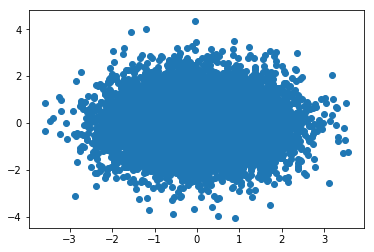

In [7]:
#functiom to draw samples from the prior distribution
def P_z(size,type=None):
    if size[1] is 2:
        #samples at 2D 10-giassuain mix
        p=np.random.randint(low=0, high=10, size=(size[0],1))
        samples_x=np.zeros((size[0],1))
        samples_y=np.zeros((size[0],1))

        r=4
        theta=np.pi*2/10
        for i in range(10):
            samples_x+=(p==i)*np.random.normal(loc=r*(np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
            samples_y+=(p==i)*np.random.normal(loc=r*(-np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
        return np.hstack([samples_x,samples_y]).astype(floatX)
    else:
        return np.random.normal(size=size).astype(floatX)

#Esamples of samples from the mixutre distribution
Z=P_z(size=(10000,myOpts.n_hidden))
print np.shape(Z)
plt.scatter(Z[:,0],Z[:,1])

In [8]:
##Training function
def train(opts):
    train_rec,train_dis,train_enc,train_auto,anneal,  sample,encode,reconstruct,  enc,dec,dis=prep_train(opts)
    x_train,y_train,x_test,y_test,x_eval,y_eval=load_data()
    
    batches=int(float(x_train.shape[0])/opts.batchsize)

    
    #Tally of costs
    cost_rec=[] #reconstruction cost of the encoder, decoder net
    cost_dis=[] #aversarial cost on discriminator
    cost_enc=[] #adversarial cost on encoding
    test_cost_rec=[] #reconstruction error on test set
    print 'epoch   batch   cost_dis   cost_enc   cost_rec test_cost_rec  time '
    n=0
    for e in range(opts.epoch):
        #random batches
        for b in np.random.permutation(range(batches)):
            timer = time.time()
            #Z = np.random.normal(size=(opts.batchsize,opts.n_hidden)).astype(floatX)
            Z=P_z(size=(opts.batchsize,opts.n_hidden))
            X=x_train[b*opts.batchsize:(1+b)*opts.batchsize]
            
            
            #train the autoencer (enc and dec) (w/ reconstruction loss)
            J_rec=train_rec(X)
            #train the discriminator
            J_dis=train_dis(X,Z)
            #train the encoder (w/ adversarial) 
            J_enc=train_enc(X)


            cost_dis.append(J_dis)
            cost_enc.append(J_enc)
            cost_rec.append(J_rec)
            
            #check for over fitting (try reconstruct training samples
            if n%10==0:
                mse_test,x_rec_test=reconstruct(x_test[:opts.batchsize])
            test_cost_rec.append(bce(x_rec_test,x_test[:opts.batchsize]).eval().mean())
            n+=1
                
        print "%d/%d \t %d/%d \t %.3f \t  %.3f \t %.3f \t  %.3f \t  %.2f" % (e,opts.epoch,n,batches,cost_dis[-1],cost_enc[-1],cost_rec[-1], test_cost_rec[-1], time.time()-timer)
        a=anneal()
        print a
    return sample,encode,reconstruct, cost_enc,cost_rec,cost_dis,test_cost_rec
    

In [9]:
# script ot apply trained encode, reconstruct, sample functions to x_train, x_test and x_val in batches
def apply(model, data, opts):
    output=[]
    batches=int(float(data.shape[0])/opts.batchsize)
    for b in range(batches):
        temp=model(data[b*myOpts.batchsize:(b+1)*myOpts.batchsize])
        output.append(temp)
    return np.concatenate(output)

In [ ]:
##Training 
sample,encode,reconstruct, cost_enc,cost_rec,cost_dis,test_cost_rec=train(myOpts)

In [ ]:
#Save all models:
import dill
import sys
sys.setrecursionlimit(3000)
dir='DAAE_v1_sprite_params'
np.save(dir+'/cost_enc.npy',cost_enc)
np.save(dir+'/cost_rec.npy',cost_rec)
np.save(dir+'/cost_dis.npy',cost_dis)
dill.dump(sample,open(dir+'/sample.pkl','w'))
dill.dump(encode,open(dir+'/encode.pkl','w'))
dill.dump(reconstruct,open(dir+'/reconstruct.pkl','w'))
dill.dump(myOpts,open(dir+'/myOpts.pkl','w'))

In [10]:
#load all models:
import dill,sys
sys.setrecursionlimit(3000)
dir='DAAE_v1_sprite_params'
#dir='../../Expeirments/DAAE_sprites_v1/v1_noise/DAAE_v1_sprite_params/' #where my pre-trained models are saved
sample=dill.load(open(dir+'/sample.pkl','r'))
encode=dill.load(open(dir+'/encode.pkl','r'))
reconstruct=dill.load(open(dir+'/reconstruct.pkl','r'))
myOpts=dill.load(open(dir+'/myOpts.pkl','r'))
cost_enc=np.load(dir+'/cost_enc.npy')
cost_rec=np.load(dir+'/cost_rec.npy')
cost_dis=np.load(dir+'/cost_dis.npy')

print 'sigma:',myOpts.sigma, 'n_hidden:', myOpts.n_hidden

sigma: 0.25 n_hidden: 200


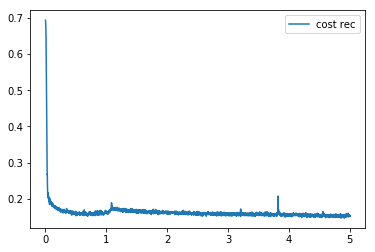

In [11]:
##Training Plots
#Cost plots
x_train,y_train,x_test,y_test,x_val,y_val=load_data()
step=1./int(float(x_train.shape[0])/myOpts.batchsize)
y=np.arange(0,myOpts.epoch,step)
#plt.plot(y,cost_dis,label='cost dis')
#plt.plot(y,cost_enc,label='cost enc')
plt.plot(y,cost_rec,label='cost rec')
#plt.plot(y,test_cost_rec, label='tect cost rec')
plt.legend()

(128, 3, 60, 60) (128, 3, 60, 60)
mean squared error loss: 0.0168039 +/- 0.00540199878141
(3, 180, 600)


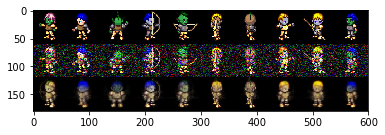

In [12]:
#Apply reconstruction to all the test images
rec=apply(reconstruct, x_test,myOpts)
x_rec=rec[1]; x_rec_loss=rec[0]
print np.shape(x_rec), np.shape(x_rec_loss)
print "mean squared error loss:", np.mean(x_rec_loss), '+/-', np.std(x_rec_loss)/np.sqrt(x_rec_loss.shape[0])
eg_test=[x_test[egs].transpose(0,2,1) for egs in range(0,120,12)]
eg_rec=[x_rec[egs].transpose(0,2,1) for egs in range(0,120,12)]
x_noise=(eg_test+myOpts.sigma*np.random.normal(size=(10,3,60,60))).clip(0,1)
im=np.dstack(np.dstack(([eg_test,x_noise,eg_rec])))
print np.shape(im)
plt.imshow(im.transpose(1,2,0))
plt.figure()

(17792, 200)


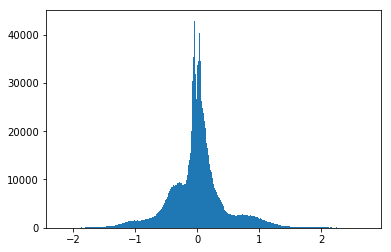

In [13]:
##Encodings
#Encode
x_enc=apply(encode,x_test,myOpts)
print np.shape(x_enc)
#Look at histrograms of encodings (For 10D Gaussian)
if myOpts.n_hidden>2:
        plt.hist(x_enc.flatten(),1000) #each axis will b diff colour
if myOpts.n_hidden==2:
    plt.scatter(x_enc[:,0],x_enc[:,1])

(3, 300, 300)


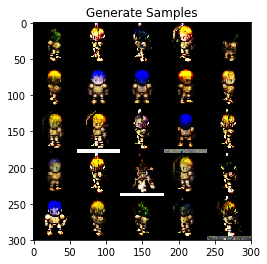

In [14]:
##Samples:
#Draw from the prior and sample (random)
row=col=5
noSamples=row*col
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_samples=sample(Z).reshape(noSamples,3,60,60)
#display as montage
montage=np.zeros((3,row*60,col*60))
n=0
for r in range(row):
    for c in range(col):
        montage[:,r*60:(r+1)*60,c*60:(c+1)*60]=x_samples[n]; n+=1;
print np.shape(montage)
plt.imshow(montage.transpose(2,1,0))
plt.title('Generate Samples')

In [15]:
## THEANO log likelihood (should be faster)
noSamples=10**3
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_sample=sample(Z)
print np.shape(x_sample)
x_sample_grey=rgb2gray(x_sample.transpose(0,3,2,1)).reshape(-1,60*60).astype(floatX)
x_val_grey=rgb2gray(x_val.transpose(0,3,2,1)).reshape(-1,60*60).astype(floatX)
x_test_grey=rgb2gray(x_test.transpose(0,3,2,1)).reshape(-1,60*60).astype(floatX)
print np.shape(x_sample_grey), np.shape(x_val_grey), np.shape(x_test_grey)

#cross val to find a sigma
batch_size=32
sigma_range = np.logspace(-1, 0, num=10)
print sigma_range
sigma = cross_validate_sigma(x_sample_grey, x_val_grey, sigma_range, batch_size)
print "sigma*=",sigma
# fit and evaulate
parzen = theano_parzen(x_sample_grey, sigma)
ll = get_nll(x_test_grey, parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_test_grey.shape[0])

print "Log-Likelihood of test set = {}, se: {}".format(ll.mean(), se)

# valid
ll = get_nll(x_val_grey, parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_val_grey.shape[0])
print "Log-Likelihood of valid set = {}, se: {}".format(ll.mean(), se)

(1000, 3, 60, 60)
(1000, 3600) (12816, 3600) (17800, 3600)
[ 0.1         0.12915497  0.16681005  0.21544347  0.27825594  0.35938137
  0.46415888  0.59948425  0.77426368  1.        ]
0.1
0 0.458135128021 1697.48499907
100 0.409625898493 1653.12660674
200 0.411634914911 1663.70436675
300 0.410416557939 1663.91509765
400 0.410429043068 1666.33004563
0.129154966501
0 0.41637301445 2088.83632113
100 0.413325151595 2062.24803316
200 0.413063568855 2068.58881463
300 0.41160706349 2068.71522541
400 0.411476373672 2070.16292069
0.16681005372
0 0.412873983383 1954.56259214
100 0.410364696295 1938.62451004
200 0.408753705855 1942.42507788
300 0.40834093886 1942.50100125
400 0.409615331754 1943.36882221
0.215443469003
0 0.40977191925 1505.19121134
100 0.412048181685 1495.6307164
200 0.41011466553 1497.90819186
300 0.409454827293 1497.95390578
400 0.407600211384 1498.47404023
0.278255940221
0 0.402567148209 866.926725798
100 0.403877650157 861.182926922
200 0.404535467945 862.546982695
300 0.406738

In [ ]:
##Iterative sampling (not for experiments 2.)

In [16]:
#display as montage
def montage(X, row=10,col=10):
    plt.figure()
    montage=np.zeros((row*60,col*60,3))
    n=0
    for r in range(row):
        for c in range(col):
            montage[r*60:(r+1)*60,c*60:(c+1)*60,:]=X[n].transpose(2,1,0); n+=1;
    plt.imshow(montage,cmap='gray')
    plt.title('Generate Samples: After MC')

Iteration: 0
Iteration: 1
Iteration: 2


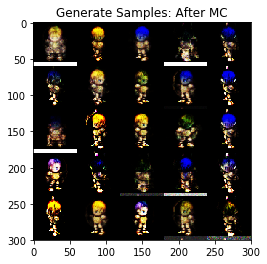

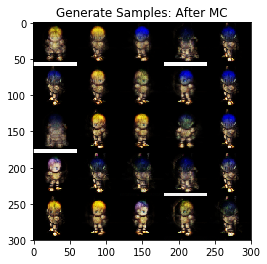

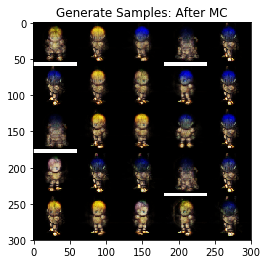

In [17]:
noSamples=10**3
z_0=np.random.normal(size=(noSamples,myOpts.n_hidden)).astype(floatX)
x_t=sample(z_0)
noSteps=2
sigmas=np.logspace(-1.,0,10)[:5]
for t in range(noSteps):
    if(t%10==0 or t<20):
        print 'Iteration:',t
        montage(x_t,5,5)
        rec_loss,x_t=reconstruct(x_t)
print 'Iteration:',t+1
montage(x_t,5,5)

In [18]:
# fit and evaulate
batch_size=32
x_t_grey=rgb2gray(x_t.transpose(0,3,2,1)).reshape(-1,60*60).astype(floatX)
x_test_grey=rgb2gray(x_test.transpose(0,3,2,1)).reshape(-1,60*60).astype(floatX)

parzen = theano_parzen(x_t_grey, sigma)
ll = get_nll(x_test_grey, parzen, batch_size = batch_size)
se = ll.std() / np.sqrt(x_test_grey.shape[0])

print "Log-Likelihood of test set = {}, se: {}".format(ll.mean(), se)

0 0.407820940018 2318.42694775
100 0.405002560946 2238.68617109
200 0.405276712494 2239.66556611
300 0.405440388328 2238.04643032
400 0.405417913213 2235.9273683
500 0.405343969901 2236.47998506
Log-Likelihood of test set = 2236.0000921, se: 4.81254332103


In [ ]:
## Visualise weights
W_dec=sample.get_shared()
W_dec0=W_dec[6].T.eval()
print np.mean(W_dec0)
print np.shape(W_dec0)
F_size=60 #"filter" size
col=row=10 #no of weights to display
W_dec_montage=np.zeros((row*F_size,col*F_size,3)).astype(floatX)
n=0
for r in range(row):
    for c in range(col):
        W_dec_montage[r*F_size:(r+1)*F_size,c*F_size:(c+1)*F_size,:]=W_dec0[:,n].reshape(3,F_size,F_size).transpose(2,1,0);
        n+=1
plt.figure()
plt.imshow(W_dec_montage[:,:,:])
plt.title('Decoder last layer weights')

In [ ]:
W_enc=encode.get_shared()
W_enc0=W_enc[0].T.eval()
print np.mean(W_enc0)
print np.shape(W_enc0)
F_size=60 #"filter" size
col=row=10 #no of weights to display
W_enc_montage=np.zeros((row*F_size,col*F_size,3)).astype(floatX)
n=0
for r in range(row):
    for c in range(col):
        W_enc_montage[r*F_size:(r+1)*F_size,c*F_size:(c+1)*F_size,:]=W_enc0[n,:].reshape(3,F_size,F_size).transpose(2,1,0);
        n+=1
plt.figure()
plt.imshow(W_enc_montage[:,:,:])
plt.title('Encode 1st layer weights')

In [ ]:
exit()